<h1 style="text-align: center;">WRE Assignment </h1>
<p style="text-align: center;">Mageline Duquesne, Marie Domingues Dos Santos, Romain Phan <br> <br>
<i>Note: all our functions are on the file "Git4.py"</i> </p>

In [21]:
import math
%run Git4.py

#Plot nice graphs
import seaborn as sns
sns.set_theme(style="whitegrid")

<h2 style="color:red">Calibration </h2>    

**1. Report the best fit parameters for the hydrological model.**

We ran our algorithm *opt_param()* with a maximum of 20,000 iterations. This lead to approximately 4,000 accepted iterations but the algorithm was unable to reach the set objective of a NS indicator greater than 0.87. Instead, it reached approximately 0.8636, which is still a good fit. Below are the exact value of the NS indicator and the associated parameters.

In [6]:
NS_best = 0.8635750303310568

K_sat_best =   9.111428972397207e-07 # [m/s]
c_best =       8.342962234370434     # [-]
t_sub_best = 108.9762134644488       # [h] 
z_best =     353.1269734122299       # [mm]

**4. Plot Markov chains of the calibrated parameters and sequences of values of N S and TSA as a function of the number of iterations. Only plot accepted parameter sets.**

![Plot of the NS indicator](images/NS_plot.jpg)

In [4]:
# todo : markov chains des autres paramètres
# images à venir

<h2 style="color:red">Hydrological variables </h2>

**2. Plot the time series (6-year-long) of precipitation [mm/h], run off [mm/h], infiltration [mm/h], soil moisture, leakage [mm/h] and evapotranspiration [mm/h] for the calibrated hydrological model forced by the given precipitation).**

Computing the hydrological model's response to our best fit parameters and the given precipitation( we use the hydr_model function that is in the Git4 file):

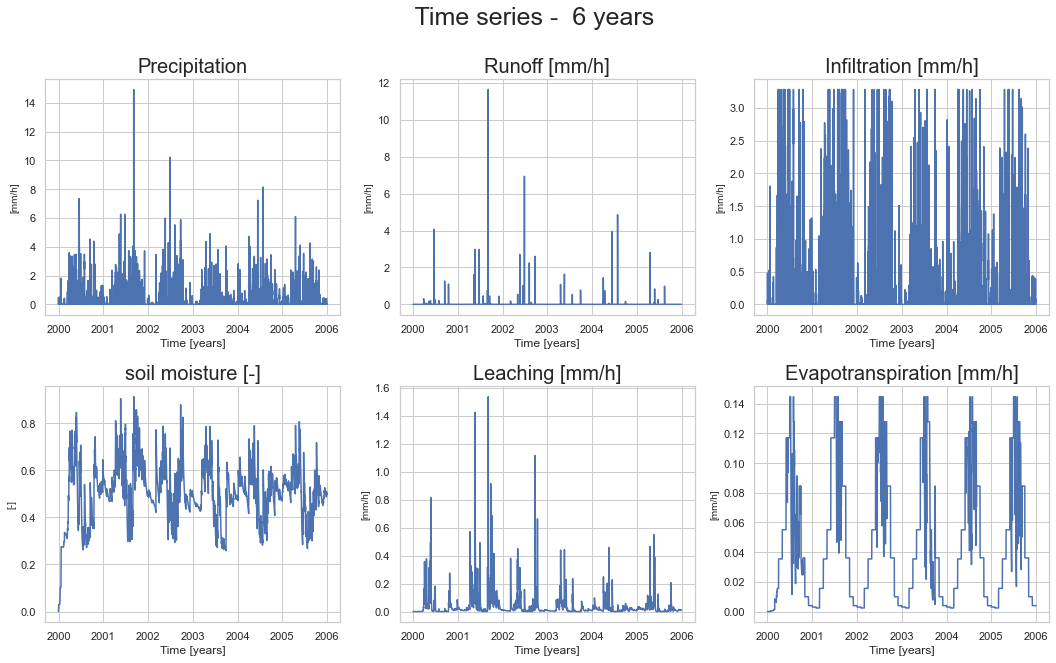

In [7]:
[Q, R, I, s, L, ET] = hydr_model(K_sat_best, c_best, t_sub_best, z_best, \
                                 precipitation, K_c, n_years=6, s_0 = 0, V_sup_0 = 0, V_sub_0 = 0)

plot_model(precipitation, R, I, s, L, ET, True) 
# set last parameter to True to plot precipitation, False to plot discharge

**Comments :** We observe that the simulated discharge , runoff and leaching present the same peaks as the observed precipitations plotted above, that is coherent. For the infiltration and the soil moisture, it is more difficult to identify peaks. We observe that Evaporation is quite periodic. That is coherent as the evaporation depend on the potential evaporation that is yearly-periodic. 

<h2 style="color:red">Discharge</h2>

__3. Plot the time series of observed discharge and of the discharge as simulated by the
        hydrological model with the best fit parameters.__

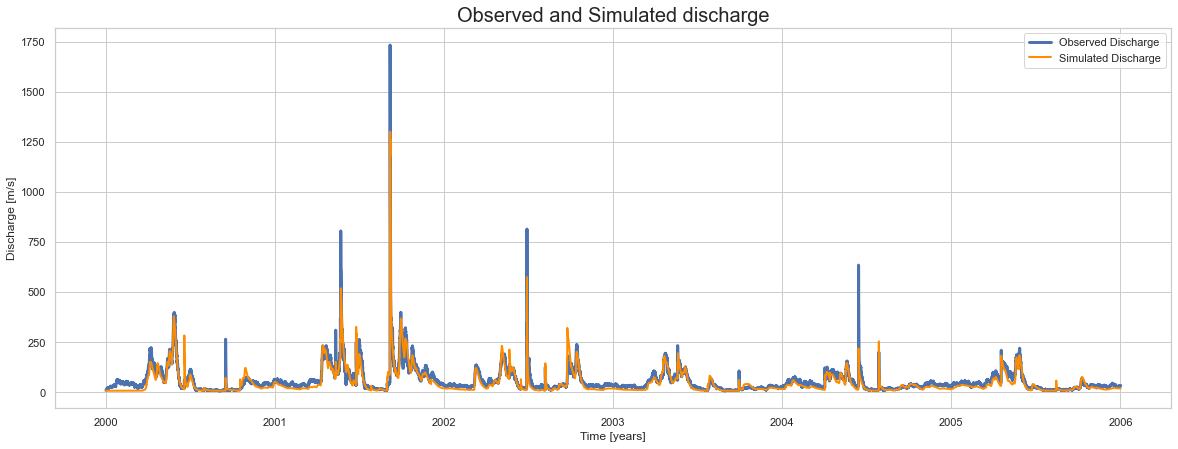

In [8]:
figure=plt.figure(figsize=(20,7))
t = [2000 + i/365/24 for i in range((len(Q)))]
plt.plot(t, Q_obs,label="Observed Discharge", linewidth=3 )
plt.plot(t, Q, label="Simulated Discharge",color="darkorange", linewidth=2)
plt.xlabel("Time [years]")
plt.ylabel("Discharge [m/s]")
plt.title("Observed and Simulated discharge",fontsize=20)
plt.legend()
plt.show()

**Comments:** We observe that simulated and observed Discharge are quite similar, the two curves overllap well during the the six years. However, pics of the observed discharge are higher than simulated ones. That is a problem of the modelisation that tend to smooth processes

<h2 style="color:red"> Generation of precipitation </h2>

**5. Plot the comparison between the statistics (mean, standard deviation, α and λ) of
the observed and generated precipitation**

In [9]:
day_month=[31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31] # number of days for each month
month_end=np.cumsum(day_month)-1                           # last day of each month
month_start=month_end-day_month+1                          # first day of each month

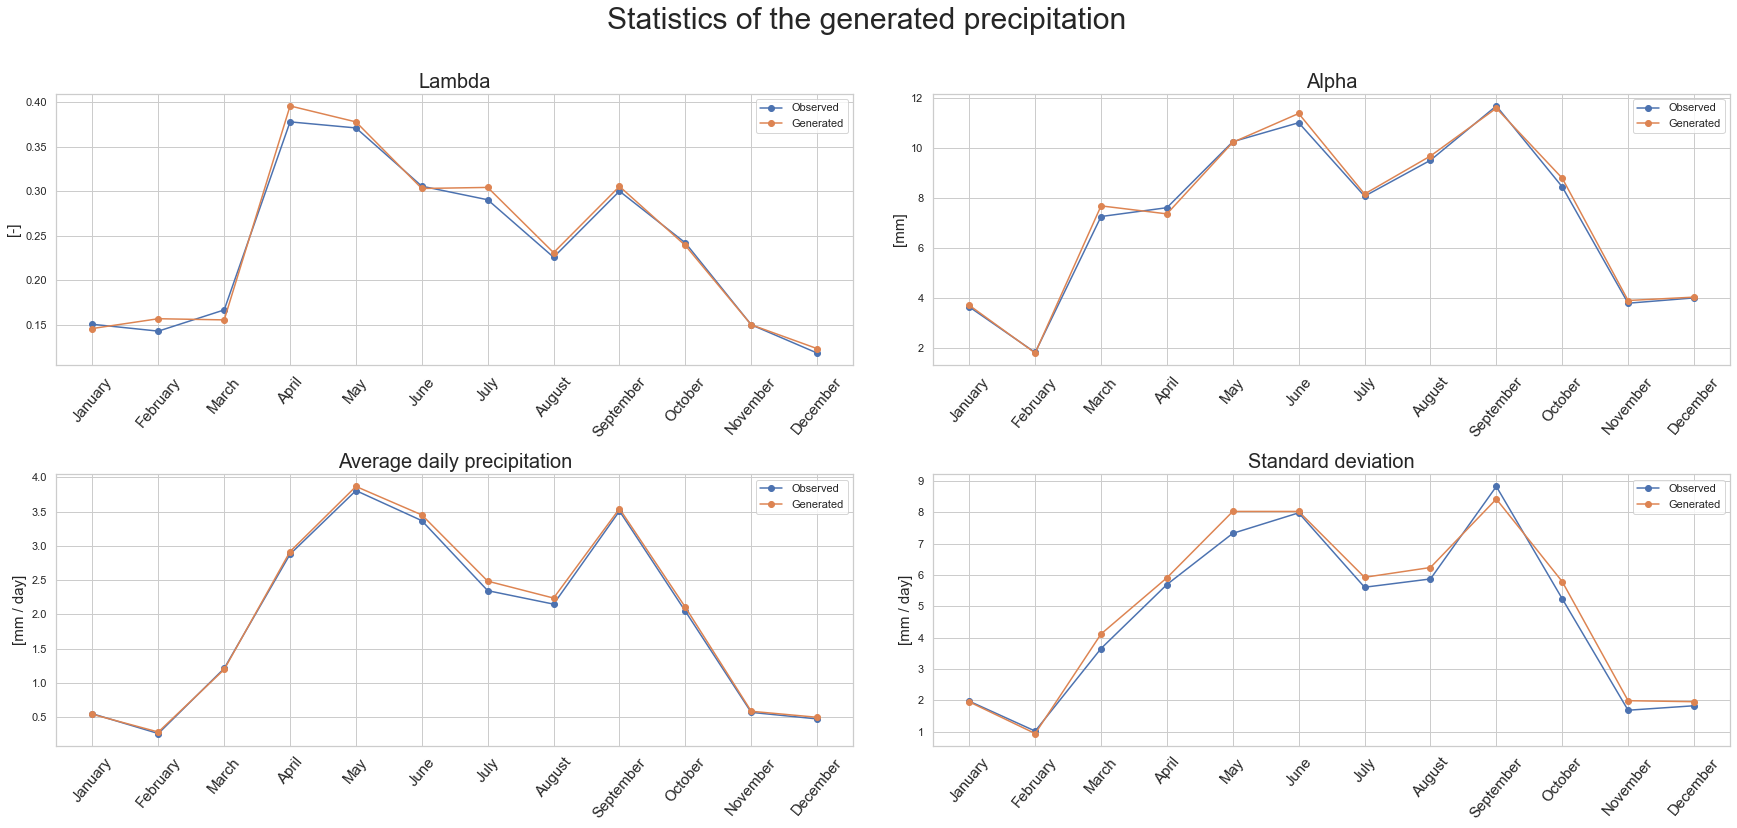

In [10]:
P=rain_gen(years=100,plot=True)

We observe a good overlapping of the different parameters. It does not mean that the generated and observed precipitations have exactly the same properties, for example, extreme events might not be correctly generated. 

<h2 style="color:red"> Simulation of hydrological variables </h2>

**6. Plot the time series (100-year-long) of generated precipitation in [mm/h], run off in
[mm/h], infiltration in [mm/h], soil moisture, leakage in [mm/h] and evapotranspiration in [mm/h] for the calibrated hydrological model forced by the generated
precipitation)**

In [11]:
[Q, R, I, s, L, ET] = hydr_model(K_sat_best, c_best, t_sub_best, z_best, \
                               P, K_c, n_years=100, s_0 = 0, V_sup_0 = 0, V_sub_0 = 0)

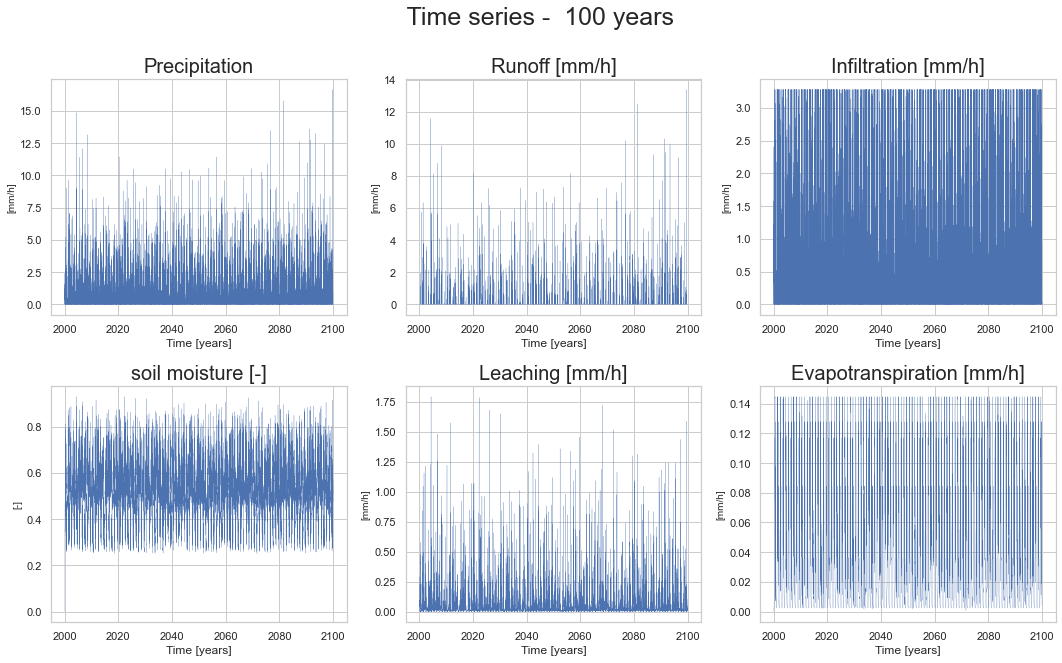

In [12]:
plot_model(P, R, I, s, L, ET, True, linewidth=0.2) # True = replace Q by P in plots

<h2 style="color:red"> Reservoir Area and Volume Rating curves </h2>

**7. Plot the area and the volume rating curves for the given levels.**

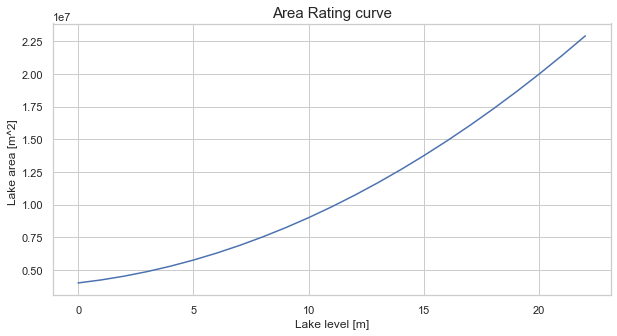

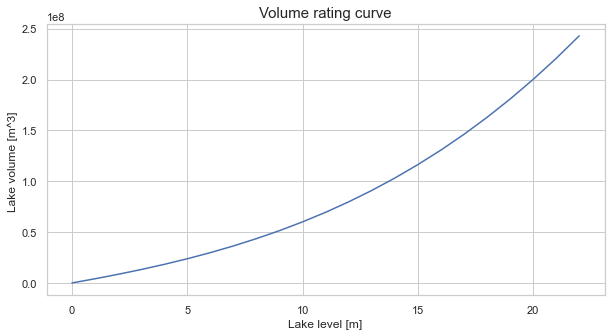

In [13]:
# AREA RATING CURVE
elevation=[k for k in range(23)]
figure=plt.figure(figsize=(10,5))
plt.plot(elevation,A_rating)
plt.xlabel("Lake level [m]")
plt.ylabel("Lake area [m^2] ")
plt.title("Area Rating curve",fontsize=15)
plt.show()

# VOLUME RATING CURVE
V_rating = vol_rat_curve(A_rating)
figure=plt.figure(figsize=(10,5))
plt.plot(elevation,V_rating)
plt.xlabel("Lake level [m]")
plt.ylabel("Lake volume [m^3] ")
plt.title("Volume rating curve",fontsize=15)
plt.show()

<h2 style="color:red"> Discharge and reservoir routing </h2>

**8. Report the minimum flow (discharge that is equalled or exceeded 95% of the time)
of the generated discharge and plot the discharge duration curves**

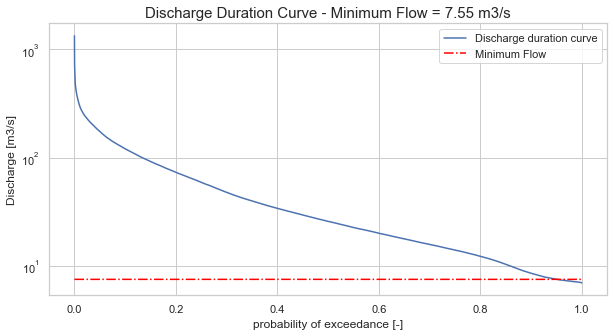

Q347 = 7.5487648518981745 [m3/s]


In [14]:
print("Q347 = " +str(Q_347(Q, plot=True))+" [m3/s]") # m3/s

<h1 style="text-align:center; color:#00AA00">Marker 1</h1>

**9. For a maximum level for hydroelectric use of 15 m, plot the time series (100 years
long) of input discharge, output discharge, volume within the reservoir and level**

In [18]:
#Energy_price=75
[Q, R, I, s, L, ET]=hydr_model(K_sat, c, t_sub, z, P, K_c, n_years=100, s_0 = 0, V_sup_0 = 0, V_sub_0 = 0)
[V,l,A_sluice,Q_out,Q_HU,Q_g,Pow,profit,p_flood,E_annual,Damages,n_year]=reservoir_routine(Q,P,ET,V_rating,lmax_HU=15)

In [19]:
print("The Annual Energy Production is = "+ str(E_annual) + " GWh")

The Annual Energy Production is = 79.18941197440387 GWh


**Comments :** This corresponds well to the order of magnitude of the annual production of a barage. The Swiss Federal Council website indicates that "677 power plants [...] produce an average of 36'741 gigawatt-hours (GWh/a) of electricity annually." That's an average of 54 GWh per dam, so our dam is above the Swiss average but in the same order in magnitude. Of course, our model is simplified, that can explain why the energy is above the swiss average.

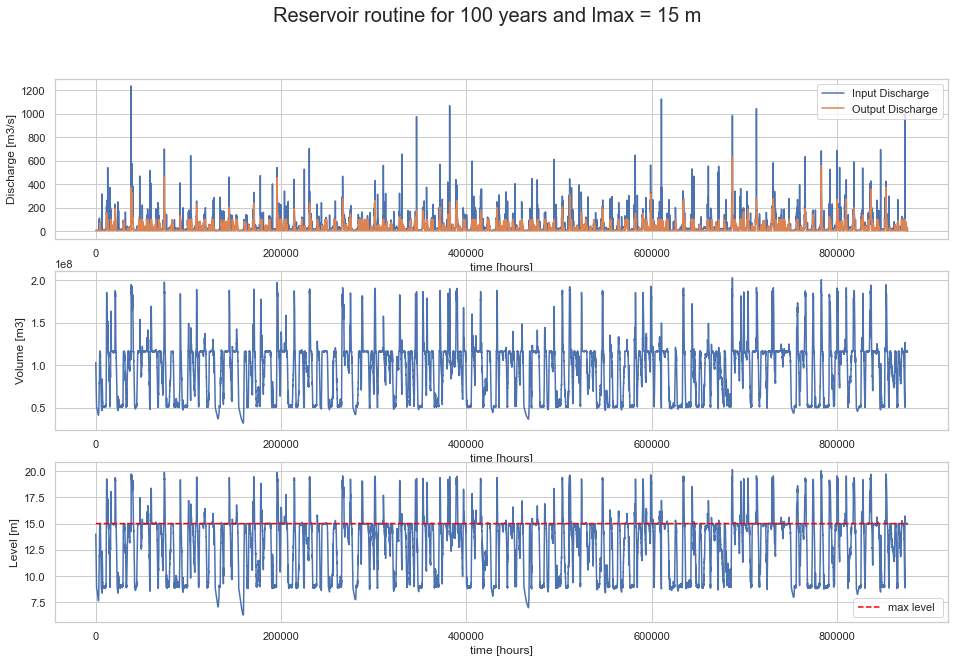

In [22]:
plot_routine(Q,Q_out,V,l,15)

**Comments :** Over 100 years, we observe many episods where the level is above the maximum level for hydropower production. 

# Check kl why 2.5?

**10. Plot the average annual energy production in [GWh] and the probability that Qout
exceeds Qlim for different values of the maximum level for hydroelectrical use.**

In [24]:
lmax=np.linspace(9,19,21)
energy=[]
money=[]
prob_flood=[]
for element in lmax:
    [V,l,A_sluice,Q_out,Q_HU,Q_g,Pow,profit,p_flood,E_annual,Damages,n_years]=reservoir_routine(Q,P,ET,V_rating,lmax_HU=element)
    energy.append(E_annual)
    money.append(profit)
    prob_flood.append(p_flood)
    
max_money=money[0]
best_l=lmax[0]
for i in range (1,len(lmax)):
    if money[i]>max_money:
                max_money=money[i]
                best_l=lmax[i]

Text(0.5, 1.0, 'Average annual energy production')

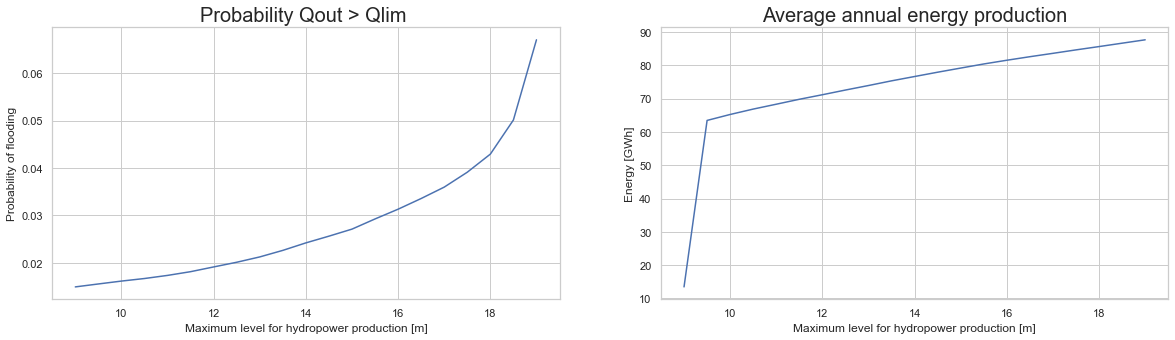

In [25]:
#plt.plot(lmax,money)
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
plt.plot(lmax,prob_flood)
ax=plt.gca()
plt.xlabel("Maximum level for hydropower production [m]")
plt.ylabel("Probability of flooding")
ax.set_title("Probability Qout > Qlim ",fontsize=20)

plt.subplot(1,2,2)
plt.plot(lmax,energy)
ax=plt.gca()
plt.xlabel("Maximum level for hydropower production [m]")
plt.ylabel("Energy [GWh]")
ax.set_title("Average annual energy production",fontsize=20)

**14. Report the value of the maximum level for hydroelectric production that maximizes
the income function**

The best level for hydropower production is  17.0 m


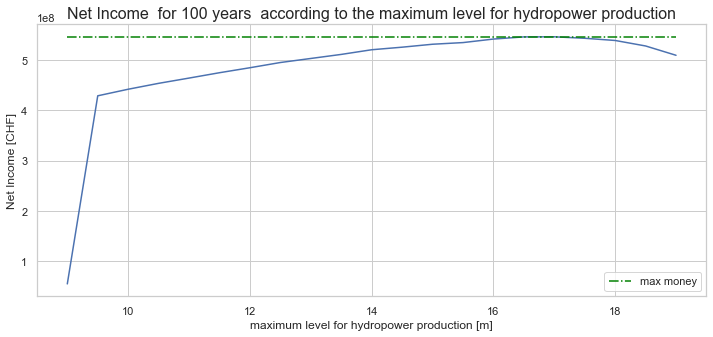

In [78]:
figure=plt.figure(figsize=(12,5))
plt.plot(lmax,money)
plt.plot(lmax,[max_money]*len(lmax),linestyle="-.", color="green",label="max money")
plt.xlabel("maximum level for hydropower production [m]")
plt.ylabel("Net Income [CHF]")
plt.title("Net Income  for "+str(int(n_year))+" years  according to the maximum level for hydropower production",fontsize=16)
plt.legend()

print("The best level for hydropower production is  " + str(best_l) +" m")

**Comments**

##  <p style="color:red">  Multi-Criteria optimization </p>

**11. Plot the Pareto front of average annual energy production in [GWh] vs the proba-
bility that Qout exceeds Qlim computed from different values of the maximum level
for hydroelectrical use.**

Text(0.5, 1.0, 'Pareto Front')

<Figure size 1440x504 with 0 Axes>

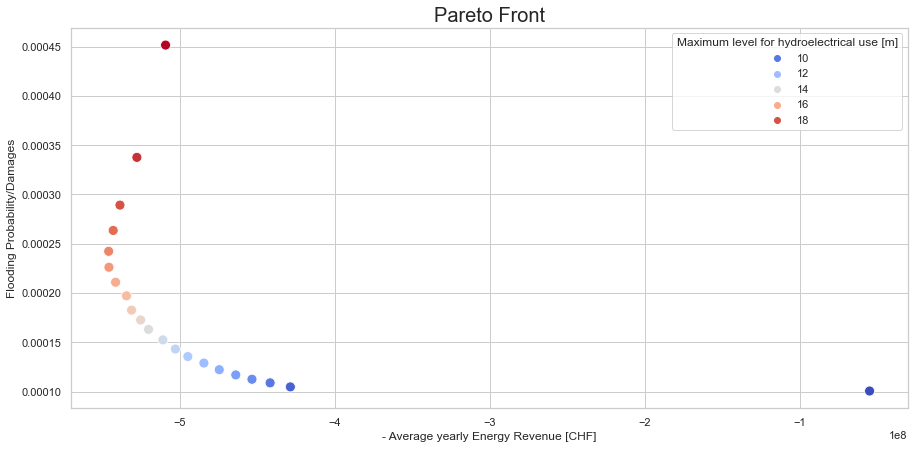

In [79]:
figure=plt.figure(figsize=(20,7))
money_r = np.array(money)    
money_n = -money_r
prob_flood_d = prob_flood/Damages
df= pd.DataFrame(lmax,columns =["Maximum level for hydroelectrical use [m]"])
#plt.plot(money_n,prob_flood_d,linestyle = 'none', marker='o', color ='red')
figure=plt.figure(figsize=(15,7))
sns.scatterplot(data=df,x=money_n,y=prob_flood_d,hue="Maximum level for hydroelectrical use [m]",palette="coolwarm",s=100)
plt.xlabel('- Average yearly Energy Revenue [CHF]')
plt.ylabel('Flooding Probability/Damages')
plt.title("Pareto Front",fontsize=20)

**12. Elaborate on why this graph could be useful when choosing one value of maximum
level for hydroelectrical use over the other.**

<h1 style="text-align:center; color:#00AA00"> TO DO</h1>

**13. Plot the revenue, expenditure, and income functions for each value of the maximum
level for hydroelectric production. The template for this picture is not provided**

<h1 style="text-align:center; color:#00AA00"> TO DO</h1>

##  <p style="color:red">  Climate change </p>

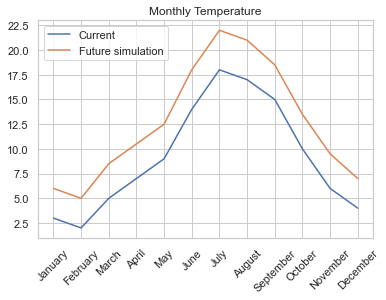

In [80]:
plt.plot(month_name,T_m,label="Current")
plt.plot(month_name,T_future,label="Future simulation")
plt.xticks(rotation=45)
plt.title("Monthly Temperature")
plt.legend()


**15. Plot the comparison of the monthly statistics of rainfall and the mean monthly dis-
charge in [m3/s] computed under the current conditions and climate change conditions.**

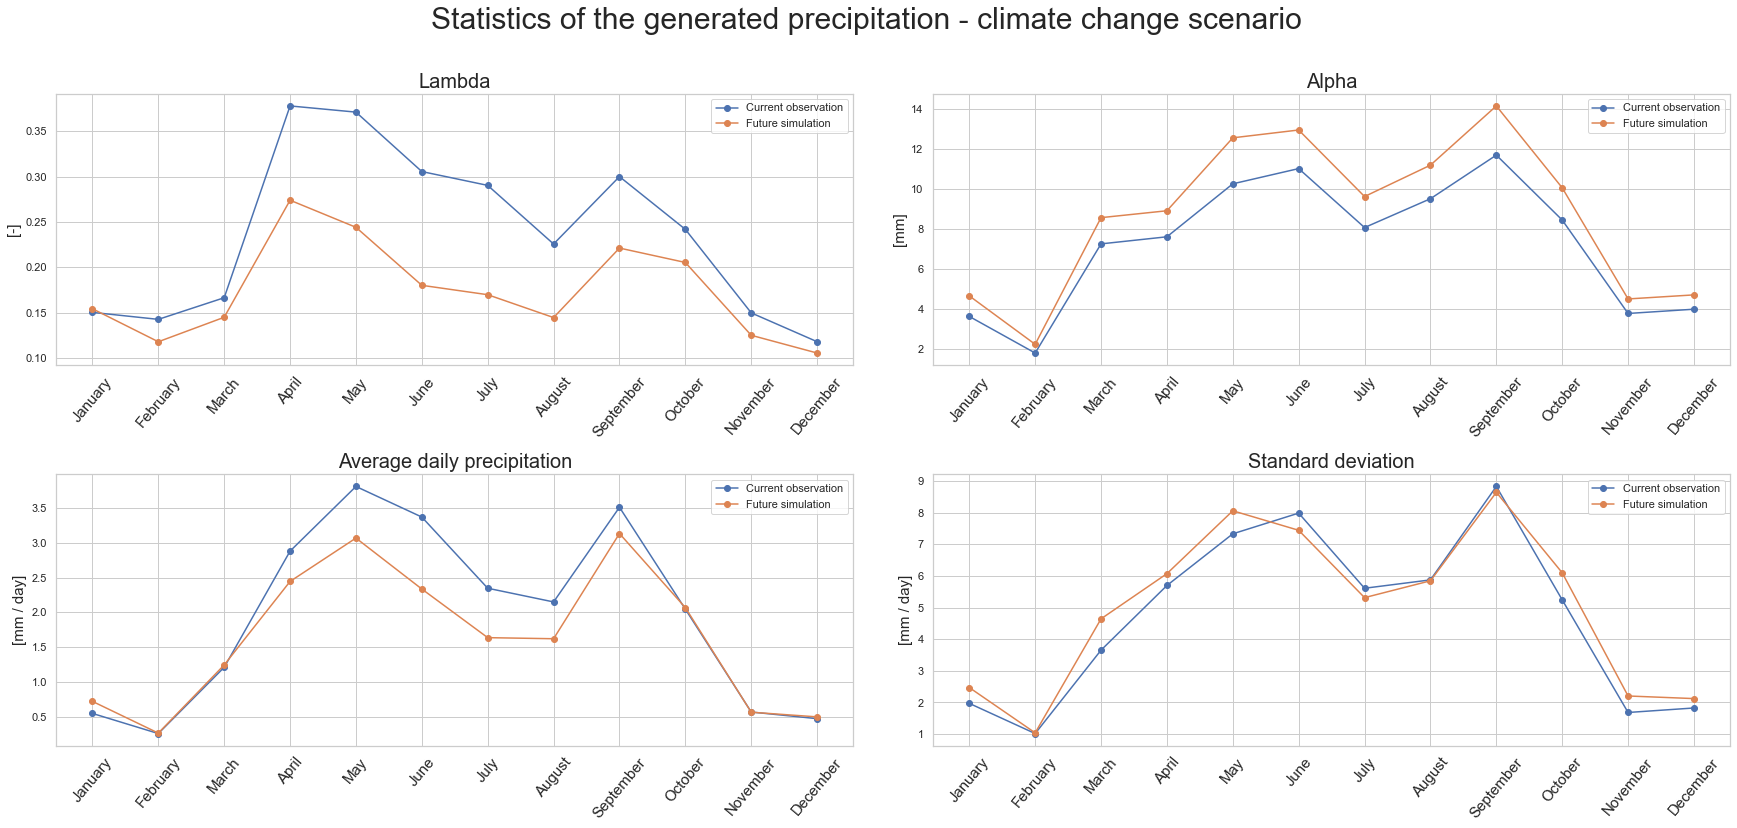

In [81]:
precipitation_change=rain_gen(years=100,plot=True,climate_change=True,alpha_c=alpha_c)


**Comments :** We observe that the monthly precipitation is lower in a climate change scenario, especially for months between April and September. The monthly standard deviation is slightly higher in the climate change scenario. Precipitation are less frequent but have an stronger intensity. It can have different consequences on the 

In [83]:
# Climate change variables
[Q_f, R_f, I_f, s_f, L_f, ET_f]=hydr_model(K_sat, c, t_sub, z, precipitation_change, K_c, n_years=100, s_0 = 0, V_sup_0 = 0, V_sub_0 = 0, T=T_future)
# Present variables for comparison
#[Q, R, I, s, L, ET]=hydr_model(K_sat, c, t_sub, z, P, K_c, n_years=6, s_0 = 0, V_sup_0 = 0, V_sub_0 = 0)

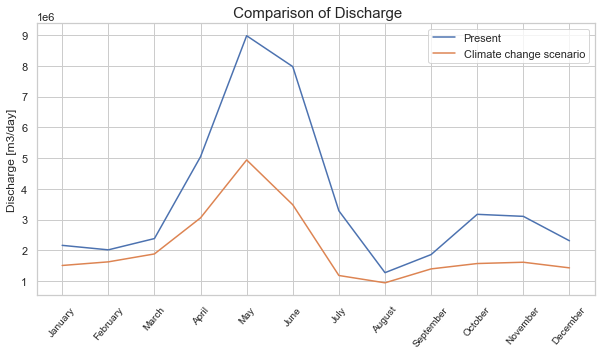

In [84]:
mQ=np.asarray(monthly_mean(Q))*3600
mQf=np.asarray(monthly_mean(Q_f))*3600
plt.figure(figsize=(10,5))
plt.plot(month_name,mQ,label="Present")
plt.plot(month_name,mQf,label="Climate change scenario")
plt.xticks(rotation=50,fontsize=10)
plt.ylabel("Discharge [m3/day]")
plt.title(" Comparison of Discharge",fontsize=15)
plt.legend()

**Comments:** We observe a strong reduction of the discharge for every month. The gap is especially high in june and october. It risks to reduce the energy production!

# Check Units 

**16. Plot the comparison between the energy production and flooding probability under
current and climate change conditions.**

In [87]:
#[V_f,l_f,A_sluice_f,Q_out_f,Q_HU_f,Q_g_f,Pow,profit_f,p_flood_f,E_annual_f,Damages_f,n_year]=reservoir_routine(Q_f,precipitation_change,ET_f,V_rating,lmax_HU=13.5)

WARNING: This part take time to run

In [89]:
lmax=np.linspace(9,19,21)
energy_f=[]
money_f=[]
prob_flood_f=[]
for element in lmax:
    [V_f,l_f,A_sluice_f,Q_out_f,Q_HU_f,Q_g_f,Pow,profit_f,p_flood_f,E_annual_f,Damages_f,n_year]=reservoir_routine(Q_f,precipitation_change,ET_f,V_rating,lmax_HU=element)
    energy_f.append(E_annual_f)
    money_f.append(profit_f)
    prob_flood_f.append(p_flood_f)
    
max_money_f=money_f[0]
best_l_f=lmax[0]
for i in range (1,len(lmax)):
    if money_f[i]>max_money_f:
                max_money_f=money_f[i]
                best_l_f=lmax[i]

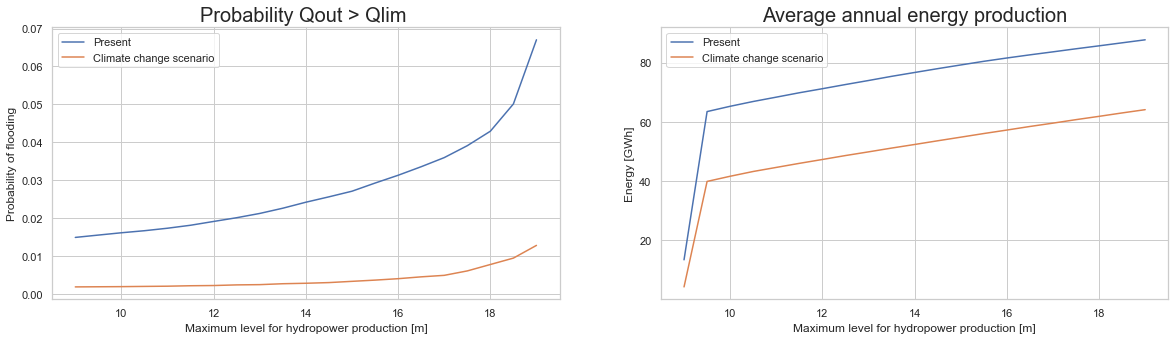

In [90]:
#plt.plot(lmax,money)
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
plt.plot(lmax,prob_flood,label="Present")
plt.plot(lmax,prob_flood_f,label="Climate change scenario")
ax=plt.gca()
plt.xlabel("Maximum level for hydropower production [m]")
plt.ylabel("Probability of flooding")
ax.set_title("Probability Qout > Qlim ",fontsize=20)
plt.legend()

plt.subplot(1,2,2)
plt.plot(lmax,energy,label="Present")
plt.plot(lmax,energy_f,label="Climate change scenario")
ax=plt.gca()
plt.xlabel("Maximum level for hydropower production [m]")
plt.ylabel("Energy [GWh]")
ax.set_title("Average annual energy production",fontsize=20)
plt.legend()

**Comments :** We observe that the probability of flooding decreases in a climate change scenario. We also observe that the average annual energy production decreases.

**17. Plot the comparison between the income function for different levels under current
and climate change conditions.**


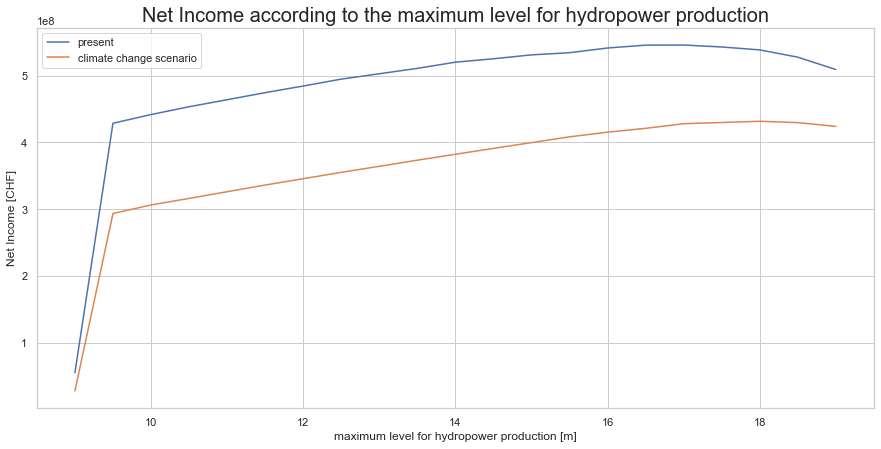

In [92]:
figure=plt.figure(figsize=(15,7))
plt.plot(lmax,money,label="present")
plt.plot(lmax,money_f,label="climate change scenario")
plt.xlabel("maximum level for hydropower production [m]")
plt.ylabel("Net Income [CHF]")
plt.title("Net Income according to the maximum level for hydropower production",fontsize=20)
plt.legend()


**18. Elaborate on the impact of climate change on the operation of the reservoir**